<a href="https://colab.research.google.com/github/KKAARRIIMM15/Computer-Vision/blob/main/Egyptian_Currency_Detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## the Author Email is **karimeldeeb2001@gmail.com**
## the Author what's up number is **+201555604511**

## **How to train Deep learning model on customized dataset for Egyptian pound Segmentation and Detection by implementing Mask R-CNN algorithm**

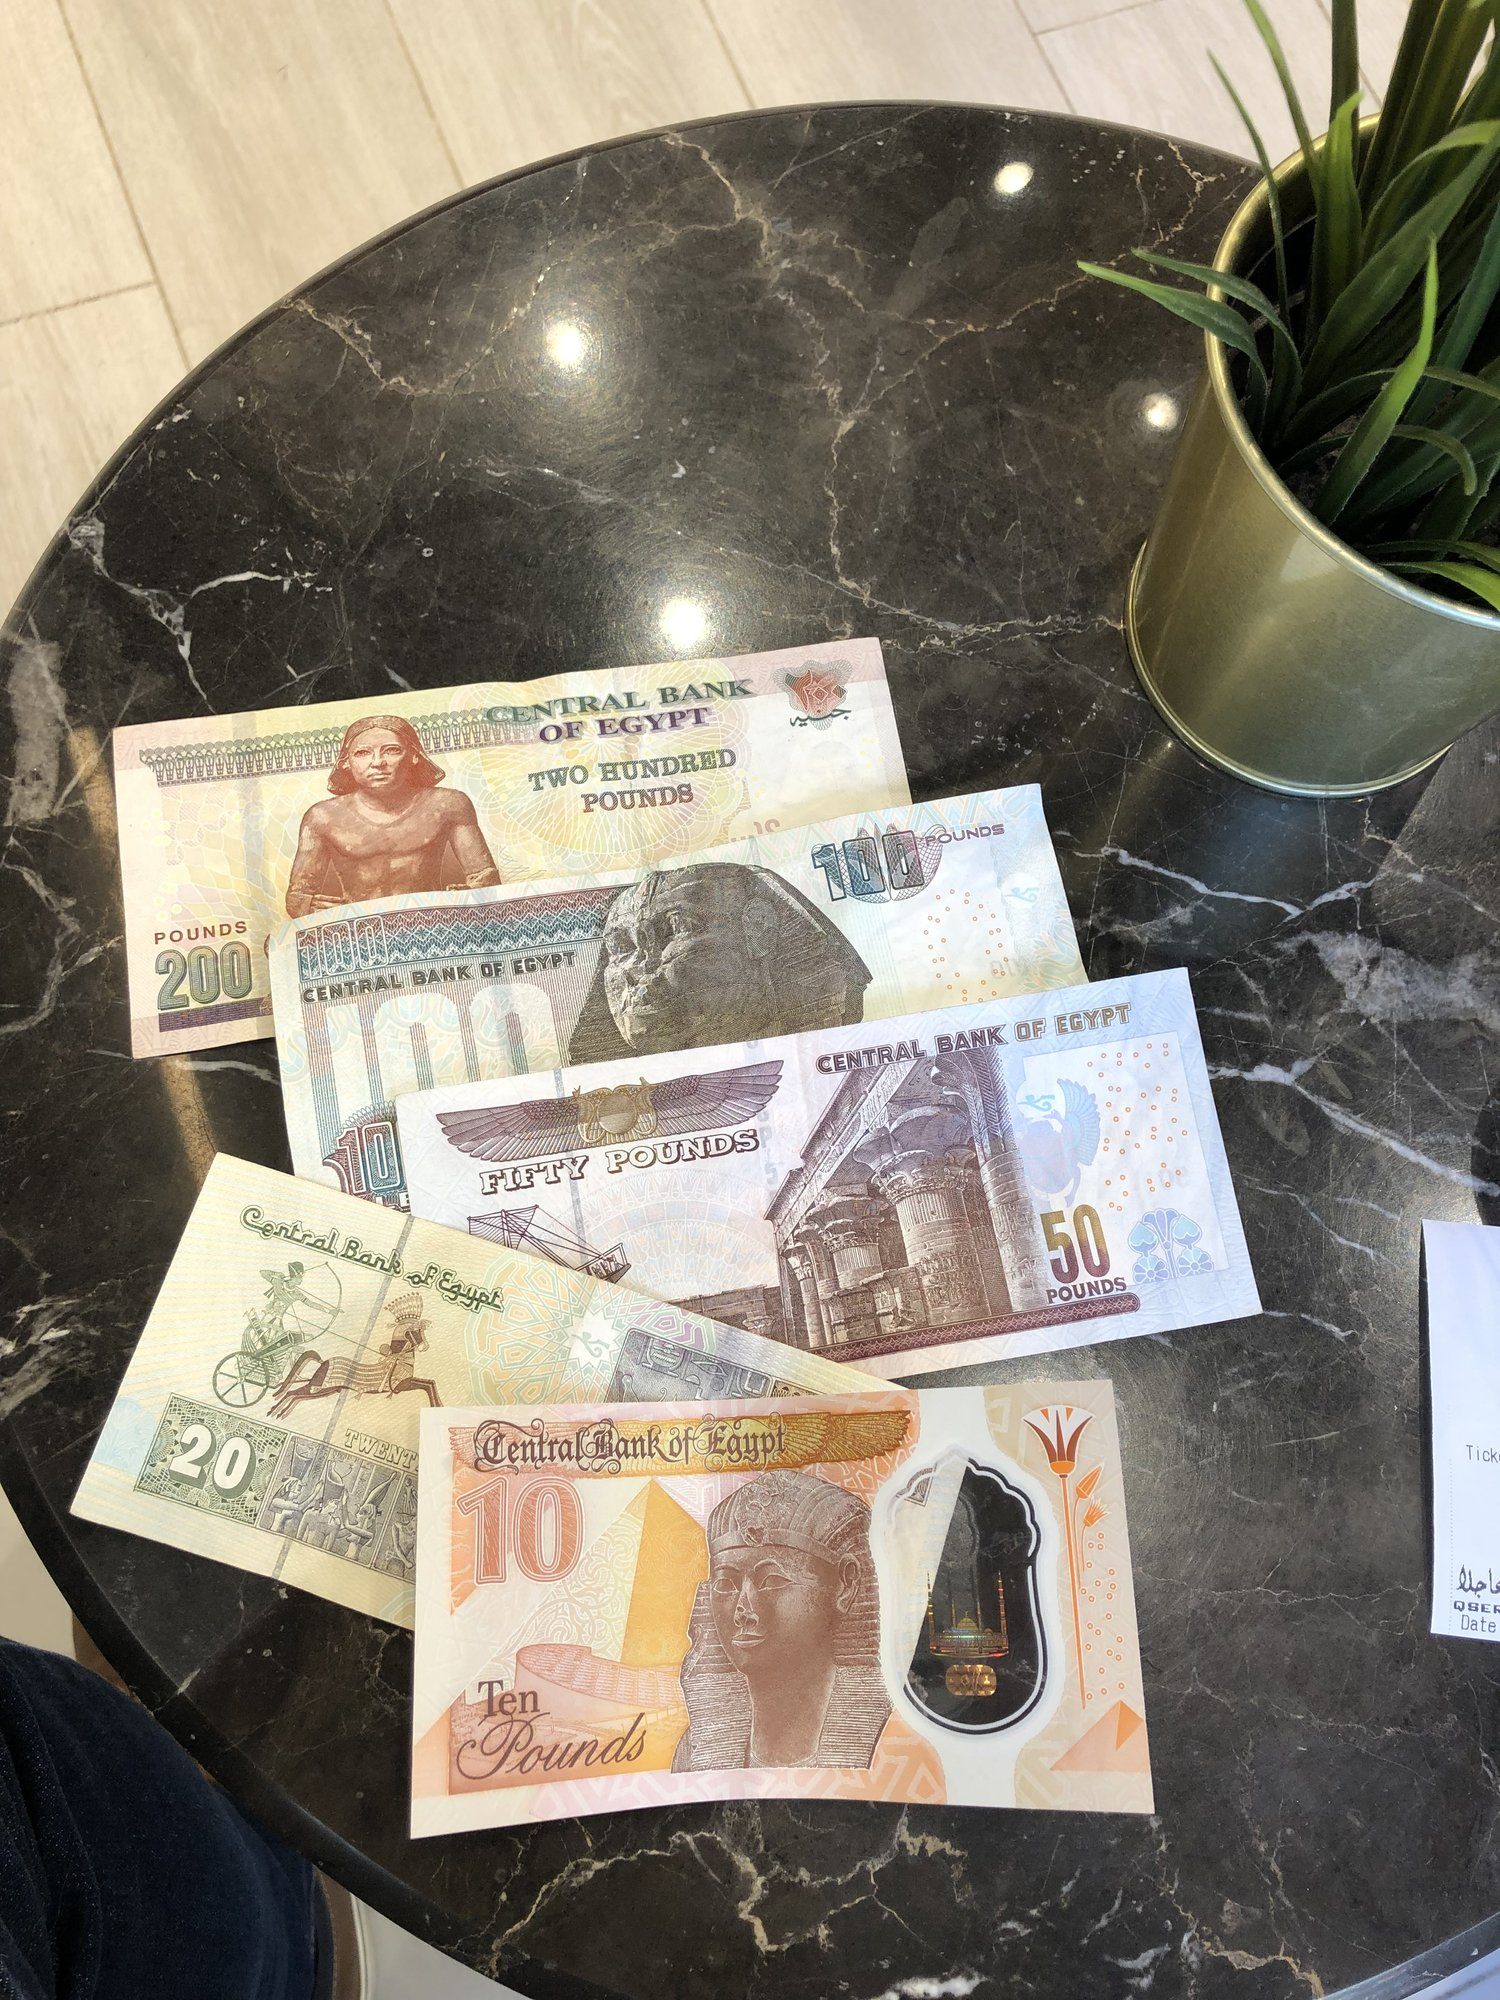

**this project shows how to use Computer Vision in real life application**
Mask R-CNN is a powerful algorithm for image instance segmentation, allowing the model to detect and isolate specific objects in images. Unlike traditional image processing techniques, Mask R-CNN can recognize fine details and contours of the currency notes even in complex environments where they may overlap or appear in different orientations

**Custom handmade dataset**

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [ ]:
!python -m pip install pyyaml
import sys, os, distutils.core

In [ ]:
!git clone https://github.com/facebookresearch/detectron2

dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [ ]:
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.config import get_cfg as _get_cfg, get_cfg
from detectron2 import model_zoo
from detectron2.utils.logger import setup_logger
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
import matplotlib.pyplot as plt  # Import matplotlib.pyplot
import numpy as np

import cv2
import warnings
warnings.filterwarnings("ignore", message="torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument.")


import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Create a Mask R-CNN with ResNet-50 backbone with FPN: which Refers to the Feature Pyramid Network**


1- "drive//MyDrive//EGP//maskRCNN" --> the path for images that will be trained

2- "drive//MyDrive//EGP//maskRCNN//_annotations.coco.json" --> the file contain the labels for each image

In [ ]:

if __name__ == "__main__":
  # to load dataset(images , labels)
    register_coco_instances("my_dataset_train", {}, "drive//MyDrive//EGP//maskRCNN//_annotations.coco.json", "drive//MyDrive//EGP//maskRCNN")  # load dataset(images , labels)
    train_metadata = MetadataCatalog.get("my_dataset_train")
    train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

    cfg = get_cfg()
    #cfg.MODEL.DEVICE = "cpu"
    cfg.MODEL.DEVICE = "cuda"   # for GPU

    cfg.OUTPUT_DIR = "drive//MyDrive//EGP"     # output path of the file that will contain the trained weights
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8

    # build a Mask R-CNN with ResNet-50 backbone with FPN: Refers to the Feature Pyramid Network
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

    cfg.DATASETS.TRAIN = ("my_dataset_train",)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 0    # num of threads for Concurrency

    # Do not load pre-trained weights
    cfg.MODEL.WEIGHTS = None

    cfg.SOLVER.IMS_PER_BATCH = 5   #Images in each batch
    cfg.SOLVER.BASE_LR = 0.00008   #learning rate
    cfg.SOLVER.STEPS = []
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # the number of regions of interest (ROIs)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8

    # Define input image size
    cfg.INPUT.MIN_SIZE_TRAIN = (1024,)
    cfg.INPUT.MIN_SIZE_TEST = 1024
    cfg.INPUT.MAX_SIZE_TRAIN = 1024
    cfg.INPUT.MAX_SIZE_TEST = 1024


# **Train the created Mask R-CNN model**

In [ ]:

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
num_images = 130  # Total number of images in your dataset
batch_size = cfg.SOLVER.IMS_PER_BATCH
epochs = 50  # Number of epochs you want to train for

# Calculate iterations per epoch
iterations_per_epoch = num_images // batch_size
cfg.SOLVER.MAX_ITER = iterations_per_epoch * epochs

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



[09/10 18:17:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

**Calculate the IOU to remove any overlap segments of the same class and take only the highest score of the same class at the same region**

In [ ]:

class Segment:
    def __init__(self, msk, scr, lbl , box):
        self.MASK = msk;    self.SCORE = scr;   self.label = lbl;  self.BOX = box


def calculate_overlap(mask1, mask2):
    # Calculate the intersection and union between two masks
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)

    # Calculate percentage of overlap as IoU
    if np.sum(union) == 0:
        return 0
    return (np.sum(intersection) / np.sum(union)) * 100


def get_overlapping_segments(segments, threshold=20):
    overlapping_segments = []

    # Check for overlap between all pairs of segments
    for i in range(len(segments)):
        for j in range(i + 1, len(segments)):
            overlap_percentage = calculate_overlap(segments[i].MASK, segments[j].MASK)
            if overlap_percentage > threshold:
                # Add segments that have sufficient overlap to the result list
                overlapping_segments.append(segments[i])
                overlapping_segments.append(segments[j])

    # Remove duplicates from the list of overlapping segments
    overlapping_segments = list(set(overlapping_segments))

    return overlapping_segments


def get_highest_score_segment(segments):
    # Ensure there are segments to compare
    if not segments:
        return None, None, None, None

    # Find the segment with the highest score
    best_segment = max(segments, key=lambda seg: seg.SCORE)

    return best_segment.MASK, best_segment.SCORE, best_segment.label, best_segment.BOX



**Load the wieghts after training the model to be used for prediction**

In [ ]:

cfg = get_cfg()

cfg.MODEL.DEVICE = "cpu"

cfg.INPUT.MIN_SIZE_TRAIN = (1024,)
cfg.INPUT.MIN_SIZE_TEST = 1024
cfg.INPUT.MAX_SIZE_TRAIN = 1024
cfg.INPUT.MAX_SIZE_TEST = 1024

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "drive//MyDrive//EGP//model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.50  # set threshold for this model

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8

predictor  = DefaultPredictor(cfg)
model = predictor.model

# Count the number of parameters
total_params = sum(p.numel() for p in model.parameters())
# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")



Total parameters: 43955712
Trainable parameters: 43733312


**Define labels and Define color to each label**

In [ ]:

# define classes
class_names = {1: "50$", 2: "5$", 3: "1" , 4: "100$" , 5: "10$" , 6: "20$" , 7: "200$" }

# define color to each class
colors = { 1: [199, 143, 20],2: [102, 15, 15], 3: [255, 254, 154],4: [114, 128, 250], 5: [139, 199, 0], 6: [205, 0, 205] , 7: [65, 0, 129] }



**this cell implement the plotting funcation only**

In [ ]:
def plot_orginal_and_segmentation( orginal_im , im ):

  orginal_im = cv2.cvtColor(orginal_im, cv2.COLOR_BGR2RGB)

  fig, axs = plt.subplots(1, 2, figsize=(12, 8))

  axs[0].imshow(orginal_im)
  axs[0].set_title('Original Image')
  axs[0].axis('off')


  axs[1].imshow(im)
  axs[1].set_title('instance segmentation')
  axs[1].axis('off')  # Hide the axes

  plt.subplots_adjust(wspace=1.0)


  plt.tight_layout()
  plt.show()



def plot_orginal_and_detection( orginal_im , im ):

  orginal_im = cv2.cvtColor(orginal_im, cv2.COLOR_BGR2RGB)

  fig, axs = plt.subplots(1, 2, figsize=(12, 8))


  axs[0].imshow(orginal_im)
  axs[0].set_title('Original Image')
  axs[0].axis('off')


  axs[1].imshow(im)
  axs[1].set_title('Detection')
  axs[1].axis('off')

  plt.subplots_adjust(wspace=1.0)


  plt.tight_layout()
  plt.show()



**Predict the segmentation mask of the (Mask R-CNN) i have already trained**

In [ ]:

def segmentation_mask( outputs ):

  pred_classes = outputs["instances"].pred_classes.to("cpu").numpy()
  pred_boxes = outputs["instances"].pred_boxes.to("cpu")
  pred_masks = outputs["instances"].pred_masks.to("cpu").numpy()
  scores = outputs["instances"].scores.to("cpu").numpy()

  all_Segments=[]

  height, width = im.shape[:2]
  colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

  for i, mask in enumerate(pred_masks):
      class_id = pred_classes[i].item()
      score = scores[i]
      box = pred_boxes[i].tensor.numpy()[0]


      sgmnt = Segment( mask , score , class_id , box)
      all_Segments.append( sgmnt )
      overlapping_segments = get_overlapping_segments(all_Segments, threshold=30)
      best_mask, best_score, cls_label, best_box = get_highest_score_segment(overlapping_segments)

      label = class_names[class_id]
      score = "{:.2f}".format(score * 100)
      #label = label + " " + score + "%"

      if best_mask is not None and best_mask.any():
        mask = best_mask;    score = best_score;   class_id= cls_label;      box = best_box
        label=""


      if( str(class_id) == "3"):  # coin
          cv2.putText(im, "1", (int(box[0]), int(box[1]-5)),
                      cv2.FONT_HERSHEY_SIMPLEX, 1.0, colors[class_id], 2, cv2.LINE_AA)
          empty_image = np.zeros((height, width, 3), dtype=np.uint8)
          empty_image[mask > 0] = [255, 255, 255]
          edges = cv2.Canny(empty_image, 50, 100)
          contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
          cv2.drawContours(im, contours, -1, colors[class_id], 2)

          continue

      cv2.putText(im, label, (int(box[0] + 30), int(box[1] + 60)),
                  cv2.FONT_HERSHEY_SIMPLEX, 1.4, colors[class_id], 3, cv2.LINE_AA)


      colored_mask[mask > 0] = colors[class_id]
      alpha = 0.7
      beta = 0.3
      gamma = 0
      im[mask == 1] = cv2.addWeighted(im[mask != 0], alpha, colored_mask[mask != 0], beta, gamma)

      empty_image = np.zeros((height, width, 3), dtype=np.uint8)
      empty_image[mask > 0] = [255, 255, 255]
      edges = cv2.Canny(empty_image, 50, 100)
      contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      cv2.drawContours(im, contours, -1, colors[class_id], 2)

  return im



**Predict the bounding box of the (Mask R-CNN) i have already trained above**

In [ ]:
def detection_box( outputs ):

  pred_classes = outputs["instances"].pred_classes.to("cpu").numpy()
  pred_boxes = outputs["instances"].pred_boxes.to("cpu")
  pred_masks = outputs["instances"].pred_masks.to("cpu").numpy()
  scores = outputs["instances"].scores.to("cpu").numpy()

  all_Segments=[]

  height, width = im.shape[:2]
  colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

  for i, mask in enumerate(pred_masks):
      class_id = pred_classes[i].item()
      score = scores[i]
      box = pred_boxes[i].tensor.numpy()[0]


      sgmnt = Segment( mask , score , class_id , box)
      all_Segments.append( sgmnt )
      overlapping_segments = get_overlapping_segments(all_Segments, threshold=30)
      best_mask, best_score, cls_label, best_box = get_highest_score_segment(overlapping_segments)

      label = class_names[class_id]
      score = "{:.2f}".format(score * 100)
      #label = label + " " + score + "%"

      if best_mask is not None and best_mask.any():
        mask = best_mask;    score = best_score;   class_id= cls_label;      box = best_box
        label=""


      if( str(class_id) == "3"):  # coin
          cv2.putText(im, "1", (int(box[0]), int(box[1]-5)),
                      cv2.FONT_HERSHEY_SIMPLEX, 1.0, colors[class_id], 2, cv2.LINE_AA)
          empty_image = np.zeros((height, width, 3), dtype=np.uint8)
          empty_image[mask > 0] = [255, 255, 255]
          edges = cv2.Canny(empty_image, 50, 100)
          contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
          cv2.drawContours(im, contours, -1, colors[class_id], 2)

          continue

      cv2.putText(im, label, (int(box[0] + 30), int(box[1] + 60)),
                  cv2.FONT_HERSHEY_SIMPLEX, 1.4, colors[class_id], 3, cv2.LINE_AA)

      cv2.rectangle(im, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), colors[class_id] , 3)

  return im



# **Model Testing**

# **Detect the Egyptian pounds (inference)**

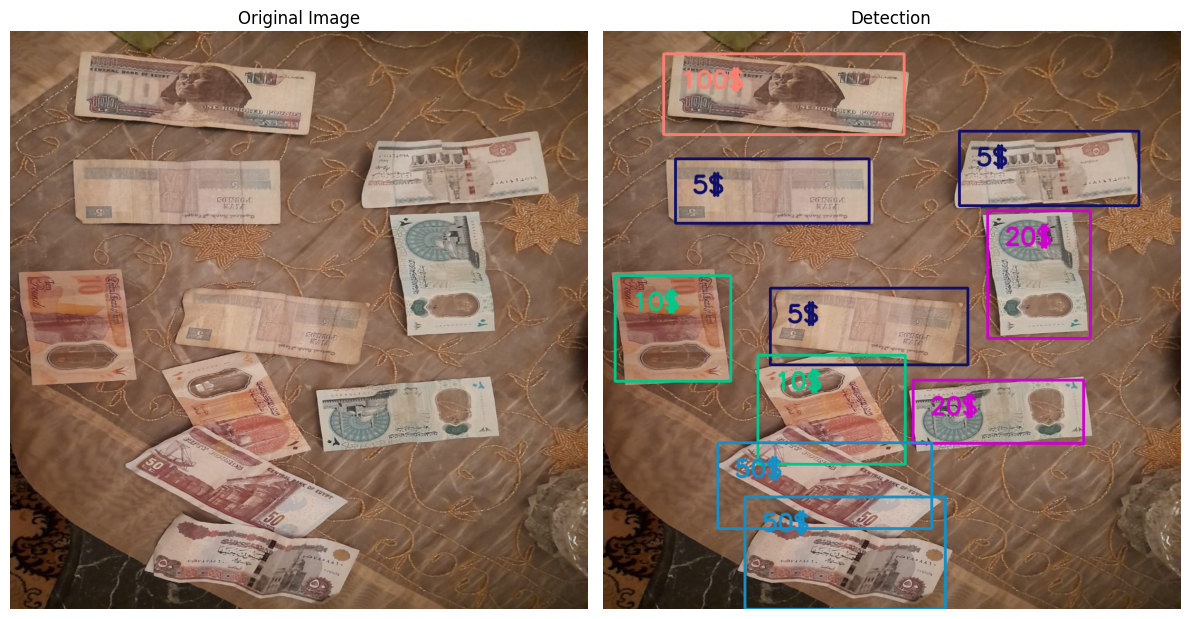

In [ ]:
im = cv2.imread("drive//MyDrive//EGP//test//t5.jpg")
im = cv2.resize(im, (1024, 1024))
outputs = predictor(im)
im = detection_box( outputs )
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

orginal_im = cv2.imread("drive//MyDrive//EGP//test//t5.jpg")
orginal_im = cv2.resize(orginal_im, (1024, 1024))
plot_orginal_and_detection( orginal_im , im )

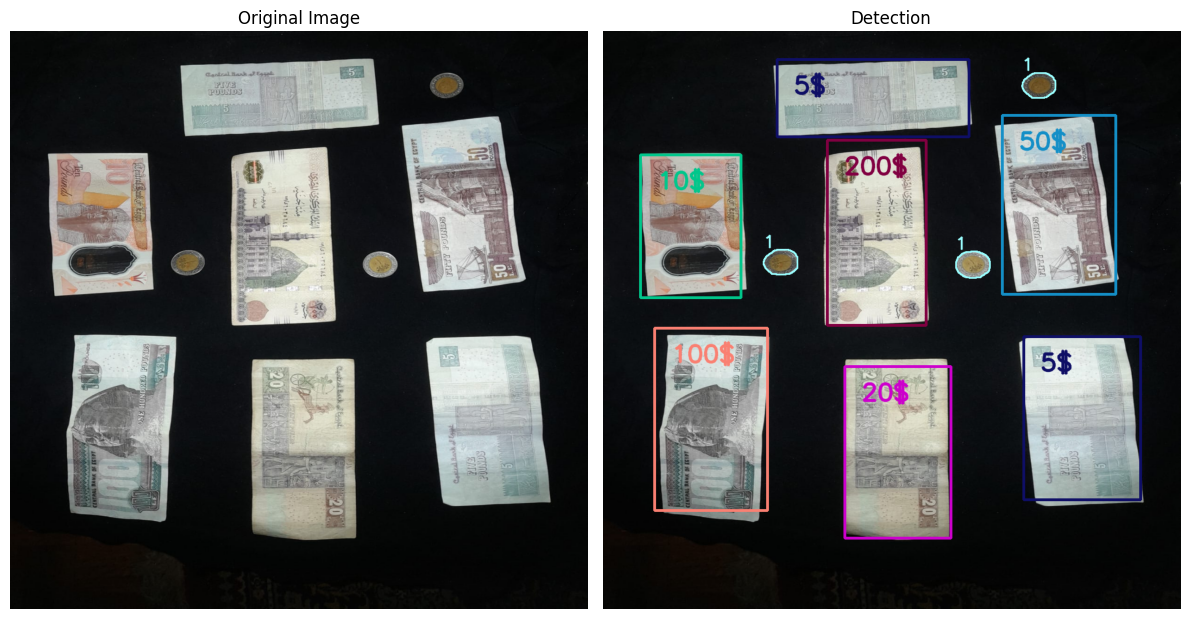

In [ ]:
im = cv2.imread("drive//MyDrive//EGP//test//t7.jpg")
im = cv2.resize(im, (1024, 1024))
outputs = predictor(im)
im = detection_box( outputs )
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

orginal_im = cv2.imread("drive//MyDrive//EGP//test//t7.jpg")
orginal_im = cv2.resize(orginal_im, (1024, 1024))
plot_orginal_and_detection( orginal_im , im )

# **Segment the Egyptian pounds (inference)**

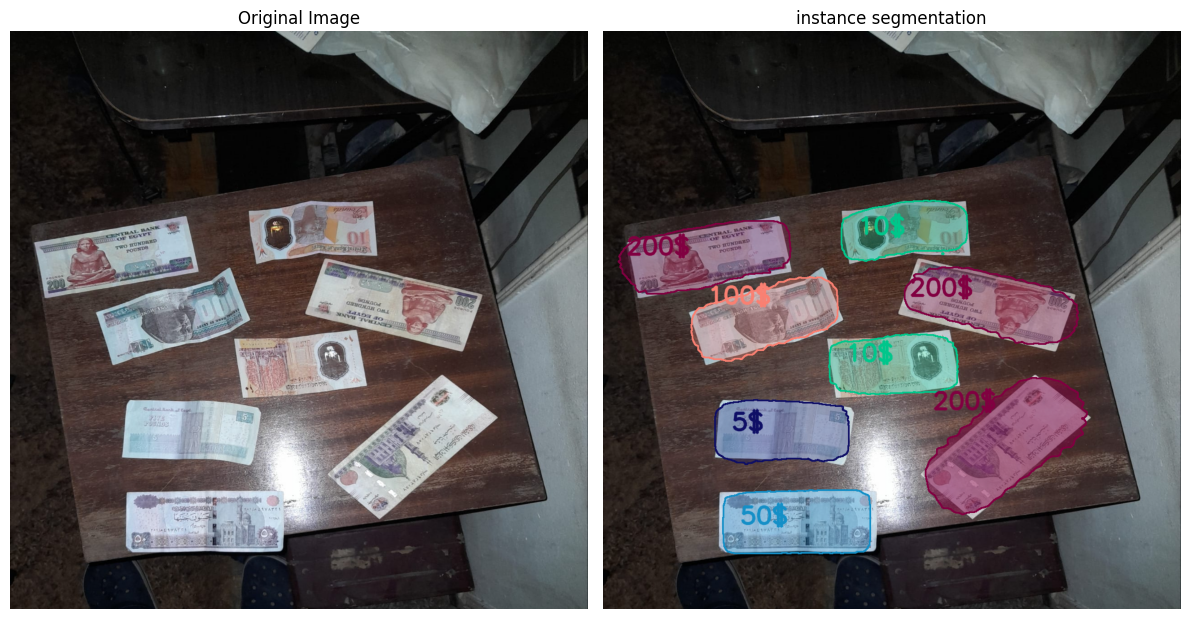

In [ ]:

im = cv2.imread("drive//MyDrive//EGP//test//t4.jpg")
im = cv2.resize(im, (1024, 1024))
outputs = predictor(im)
im = segmentation_mask( outputs )
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

orginal_im = cv2.imread("drive//MyDrive//EGP//test//t4.jpg")
orginal_im = cv2.resize(orginal_im, (1024, 1024))


plot_orginal_and_segmentation( orginal_im , im )



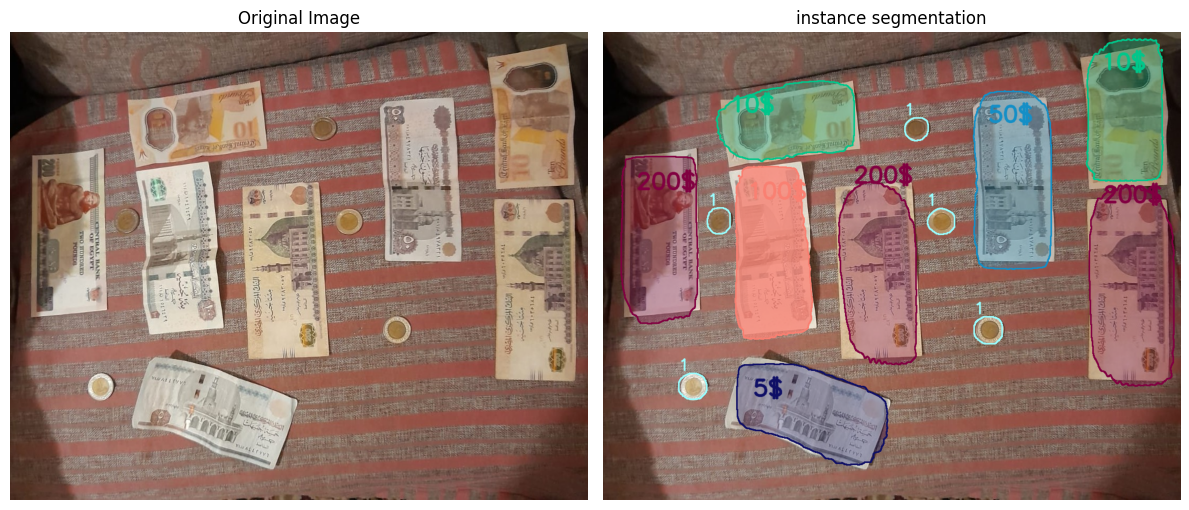

In [ ]:

im = cv2.imread("drive//MyDrive//EGP//test//t2.jpg")
outputs = predictor(im)
im = segmentation_mask( outputs )
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

orginal_im = cv2.imread("drive//MyDrive//EGP//test//t2.jpg")

#im = cv2.resize(im, (1024, 1024))
plot_orginal_and_segmentation( orginal_im , im )



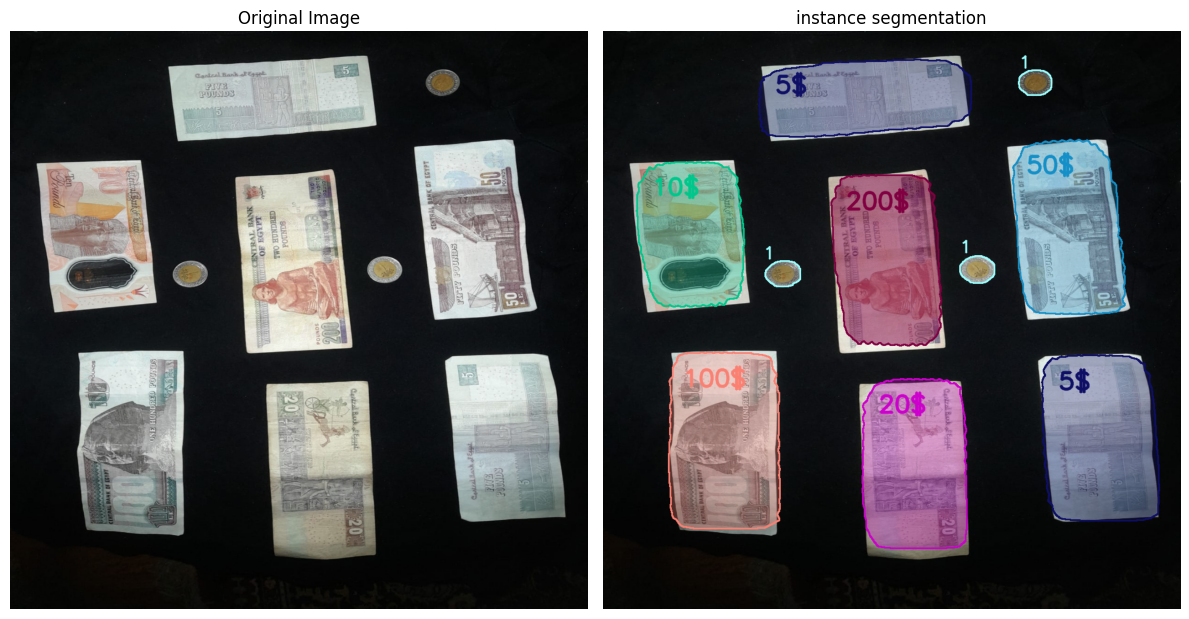

In [ ]:

im = cv2.imread("drive//MyDrive//EGP//test//t8.jpg")
im = cv2.resize(im, (1024, 1024))
outputs = predictor(im)
im = segmentation_mask( outputs )
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

orginal_im = cv2.imread("drive//MyDrive//EGP//test//t8.jpg")
orginal_im = cv2.resize(orginal_im, (1024, 1024))


plot_orginal_and_segmentation( orginal_im , im )



# **Why Mask R-CNN algorithm for Currency Notes?**


**1- Object detection:** Currency notes often overlap or have complex features. Mask R-CNN can accurately locate each note, even if they are stacked or in different orientations.

**2-Instance segmentation:** Unlike regular object detection models, Mask R-CNN provides a pixel-by-pixel mask, which is useful for separating overlapping or closely placed currency notes.

**3-High accuracy:** Mask R-CNN builds on top of advanced models (like Faster R-CNN), meaning it's very good at accurately detecting and segmenting objects.